# Introduction

In the modern digital era, vast quantities of information exist within historical documents, handwritten notes, and scanned images. To effectively process and extract meaningful data from these sources, document binarization plays a critical role. Binarization, the process of converting grayscale images into clear black and white representations, isolates textual content from backgrounds. This fundamental preprocessing step paves the way for advanced techniques like optical character recognition (OCR), document analysis, and digital preservation.

## Dataset

The DIBCO Datasets: A Rigorous Benchmark for Document Binarization

The Document Image Binarization Contest (DIBCO) datasets serve as a valuable standard for evaluating and developing document binarization techniques. These datasets contain a diverse range of challenging images that mirror real-world document degradation, such as historical manuscripts with faded text, uneven lighting, and complex backgrounds. By testing binarization algorithms on DIBCO datasets, their robustness in handling these complexities can be thoroughly assessed.

Relevance to the Assignment

The DIBCO datasets offer a well-defined environment for the objectives of this assignment. Exploring two selected binarization techniques using DIBCO images allows for a systematic evaluation of their effectiveness in addressing realistic document quality issues. Combining quantitative performance measures with a qualitative examination of the binarized results will illuminate the strengths and weaknesses of different algorithms in different scenarios. This analysis, grounded in the DIBCO benchmarks, fosters a critical understanding of binarization complexities


# Methodology

## Technique 1: Otsu's Global Thresholding

### Description:

This classic method finds a single threshold value that best separates foreground (text) from background across the entire image by minimizing within-class variance.

### Justification:

Computational efficiency: Great for situations where speed is paramount.
Good baseline: Useful as a starting point for comparison, especially when images have relatively uniform contrast.

### Steps:

Grayscale Conversion: If not already grayscale, convert the image.
Histogram Calculation: Compute the image histogram (the distribution of pixel intensities).
Iterative Threshold Testing: Test all possible threshold values, dividing pixels into two classes.
Variance Calculation: For each threshold, calculate within-class variance (how spread out each class is).
Optimal Threshold: Select the threshold yielding the minimum within-class variance.
Binarization: Apply the threshold, pixels darker become background (0), lighter become foreground (1).

```mermaid
flowchart TD

    Image --> Grayscale["Grayscale Conversion"]
    Grayscale --> Histogram["Histogram Calculation"]
    Histogram --> Thresholds["Iterate Thresholds (Calculate Variances)"]
    Thresholds --> Optimal["Select Optimal Threshold"]
    Optimal --> Binarize["Binarization"]


```

## Technique 2: Sauvola's Adaptive Thresholding

### Description:

Calculates a local threshold for each pixel based on the mean and standard deviation within its neighborhood.

### Justification:

Handles uneven illumination: Better for documents with significant lighting variations or background noise.
Preserves detail: More likely to maintain fine details in faded or degraded text

### Steps

Grayscale Conversion: If not already grayscale, convert the image.
Window Size: Select a window size (e.g., 15x15 pixels).
Pixel-wise Calculation: For each pixel:
Calculate the mean (m) and standard deviation (s) of the pixel values within its window.
Determine the threshold: T = m [1 + k (s/R - 1)] (where k is a parameter and R is the dynamic range of standard deviation)
Binarization: Compare each pixel's intensity to its local threshold. Pixels darker become background (0), lighter become foreground (1).


```mermaid
flowchart TD
    Image --> Window["Windowing Process"]
    Window --> Pixel["For Each Pixel (Calculate mean, std. dev, threshold)"]
    Pixel --> Binarize["Binarization"]
```


# Implementation and Evaluation




In [1]:
from pathlib import Path
import cv2 as cv
import os
import numpy as np
import pandas as pd
from skimage.filters import threshold_niblack,threshold_sauvola
import matplotlib.pyplot as plt
import sys

if "google.colab" in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')
  !cp -a "/content/drive/MyDrive/MS/Binarization/GT" .
  !cp -a "/content/drive/MyDrive/MS/Binarization/Dataset" .
  !cp -a "/content/drive/MyDrive/Colab Notebooks/cv_assgn1/helpers.py" .
  path = Path("/content")
  from helpers import *
else:
  path = Path("D:/MS/Binarization")
  from  cv_assgn1.helpers import *
train_path = path / "Dataset"
gt_path = path / "GT"
data = os.listdir(train_path)
results = pd.DataFrame(columns = ['Method','Denoising','Precision','Recall','F Measure'])
tick,cross = '\u2713','\u2717'


In [2]:
def apply_thresholds(data, range=(0, 1), method="global", denoise=False, retain=False):
    precisions = []
    recalls = []
    f_scores = []
    binarized = []
    ground_truths = []
    originals = []

    thresholds = np.arange(range[0], range[1])
    for t in thresholds:
        true_positive = 0
        false_positive = 0
        false_negative = 0
        for path in data:
            if not path.endswith(".txt"):
                img = cv.imread(str(train_path / path))
                if retain:
                    originals.append(cv.cvtColor(img, cv.COLOR_BGR2RGB))
                img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
                gt = cv.imread(str(gt_path / path), cv.IMREAD_GRAYSCALE)
                if denoise:
                    # img = cv.fastNlMeansDenoising(img)
                    img = cv.bilateralFilter(img, 9, 75, 75)
                if method == "adaptive":
                    b = cv.adaptiveThreshold(
                        img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2
                    )
                elif method == "global":
                    _, b = cv.threshold(img, t, 255, cv.THRESH_BINARY)
                elif method == "otsu":
                    th, b = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
                elif method == "sauvola":
                    s_th = threshold_sauvola(
                        img,
                    )
                    b = img > s_th
                    b = np.where(b == True, 255, 0)
                elif method == "niblack":
                    nib_th = threshold_sauvola(img)
                    b = img > nib_th
                    b = np.where(b == True, 255, 0)

                if retain:
                    binarized.append(b)
                    ground_truths.append(gt)
                true_positive += TP(b, gt)
                false_positive += FP(b, gt)
                false_negative += FN(b, gt)
        p = precision(true_positive, false_positive)
        r = recall(true_positive, false_negative)
        if t % 50 == 0:
            print(f"Threshold:{t} precision:{p}, recall:{r}")
            print(f"TP:{true_positive} FP:{false_positive}, FN:{false_negative}")
        precisions.append(p)
        recalls.append(r)
        f_scores.append(f_measure(p, r))
    return (
        precisions,
        recalls,
        f_scores,
        thresholds,
        binarized,
        ground_truths,
        originals,
    )

## Evaluation Metrics and their Significance

One simple but naive way to evaluate binarization algorithms is to calculate their 'accuracy' by dividing 'total number of correctly classified pixels' with 'total number of pixels'. The problem with accuracy is that if the data set is highly biased, as is the case with documents (high number of backround pixels vs small number of text pixels), then accuracy doesn't give you a good measure of quality of binarization. For example, if the image contains 99 white(background) pixels and 1 black (text) pixel, and the algorithm correctly classifies all background pixels, but incorrectly classifies the single black pixels, then accuracy will still be 99%. But the cost of black pixels(text) is more important to us. Hence Precision, Recall and F measures were used.
Precision focuses on the correctness of positive predictions. It tells us "Of all the instances predicted as positive, how many are actually positive?".
Recall measures the ability of the classifier to identify all positive instances. It tells us that "Of all the positive instances, how many did the classifier correctly identify?"

## Baseline

It is a good idea to first try the simplest algorith as a baseline before trying more complex algorithms. Because there is no point of using a complex algorithm if the simpler algorithm is giving us the desired performance.

Global thresholding was used as a baseline. Thresolds in the range of 10 to 250 were applied iteratively and their precision and recalls were compared.

Threshold:50 precision:0.7363562729232795, recall:0.30360088148920517
TP:951834 FP:340793, FN:2183315
Threshold:100 precision:0.2918710022058565, recall:0.9431790961131353
TP:2957007 FP:7174205, FN:178142
Threshold:150 precision:0.13508836733818225, recall:0.9911713924920315
TP:3107470 FP:19895769, FN:27679
Threshold:200 precision:0.11336028008918927, recall:0.9993741924227525
TP:3133187 FP:24506009, FN:1962
Threshold:250 precision:0.09085174825312631, recall:0.9999614053430953
TP:3135028 FP:31372046, FN:121


<Axes: xlabel='Threshold'>

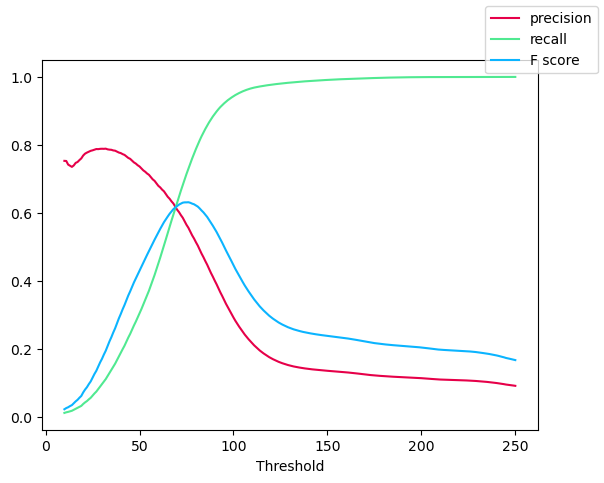

In [3]:
p, r, f, t, b, gt, og = apply_thresholds(data, (10, 251), method="global")
plot_prf(p, r, f, t)

As we increase the global threshold, precision increases but the recall decreases because almost all pixels as classified as text. The three curved intersected at threshold of 69. This gives us a baseline precision and recall value of 0.61 each.


In [4]:
# np.save('p.npy', np.array(p))
# np.save('r.npy', np.array(r))
# np.save('f.npy', np.array(f))

Threshold:[69] precision:[0.6184195533089171], recall:[0.612801177870653], fscore:[0.6155975465469579]


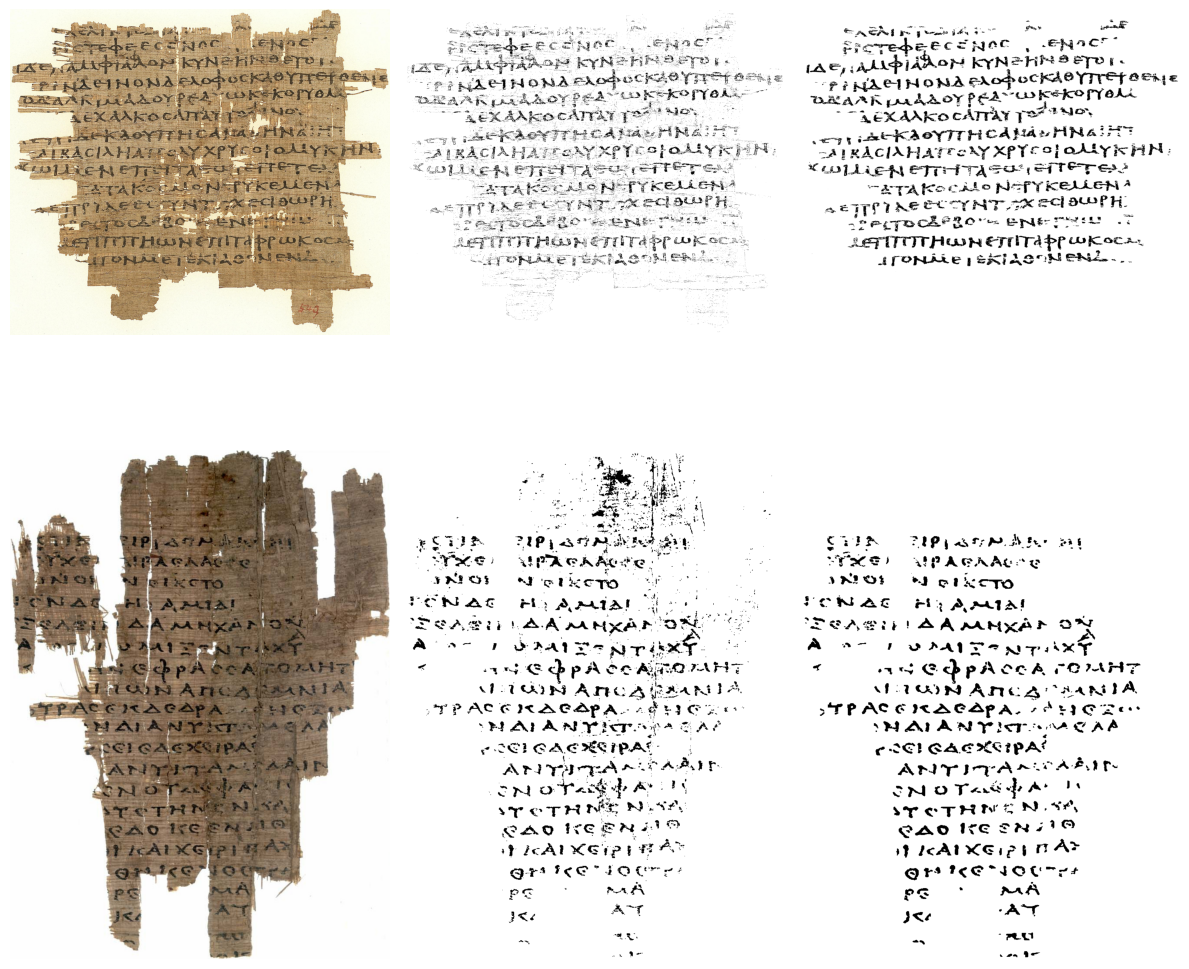

In [5]:
p, r, f, t, b, gt, og = apply_thresholds(data, (69, 70), denoise=False, retain=True)
print(f"Threshold:{t} precision:{p}, recall:{r}, fscore:{f}")
show_images(og, b, gt,2)
results.loc[len(results)] = ["Global (69)", cross, p[0], r[0], f[0]]

## global thresholding with donoising


Threshold:[76] precision:[0.6465596101620006], recall:[0.6350693380123241], fscore:[0.6407629668415349]


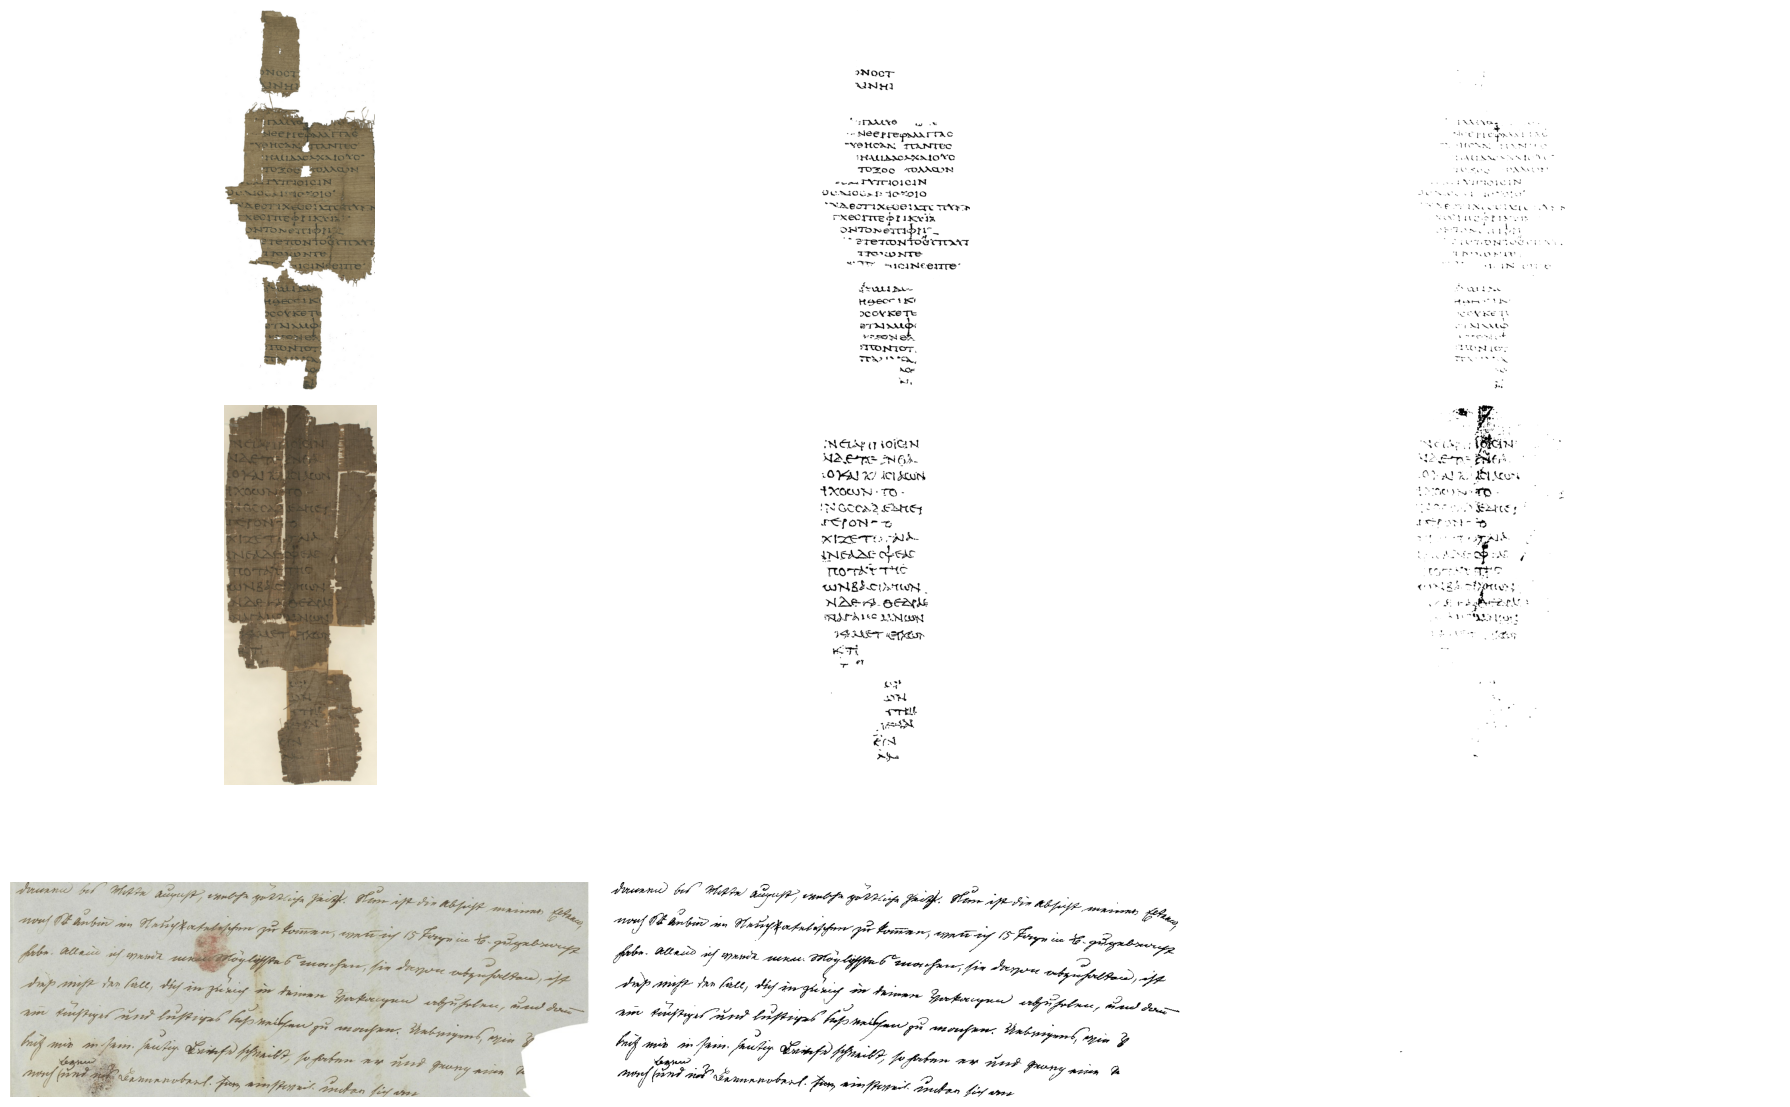

In [6]:
p, r, f, t, b, gt, og = apply_thresholds(data, (76, 77), denoise=True, retain=True)
print(f"Threshold:{t} precision:{p}, recall:{r}, fscore:{f}")
show_images(og, gt, b)
results.loc[len(results)] = ["Global (76)", tick, p[0], r[0], f[0]]

# OTSU


Threshold:0 precision:0.13639000067897358, recall:0.9944047316411437
TP:3117607 FP:19740425, FN:17542
Threshold:0 precision:0.12957564161436597, recall:0.9924657488368176
TP:3111528 FP:20901689, FN:23621


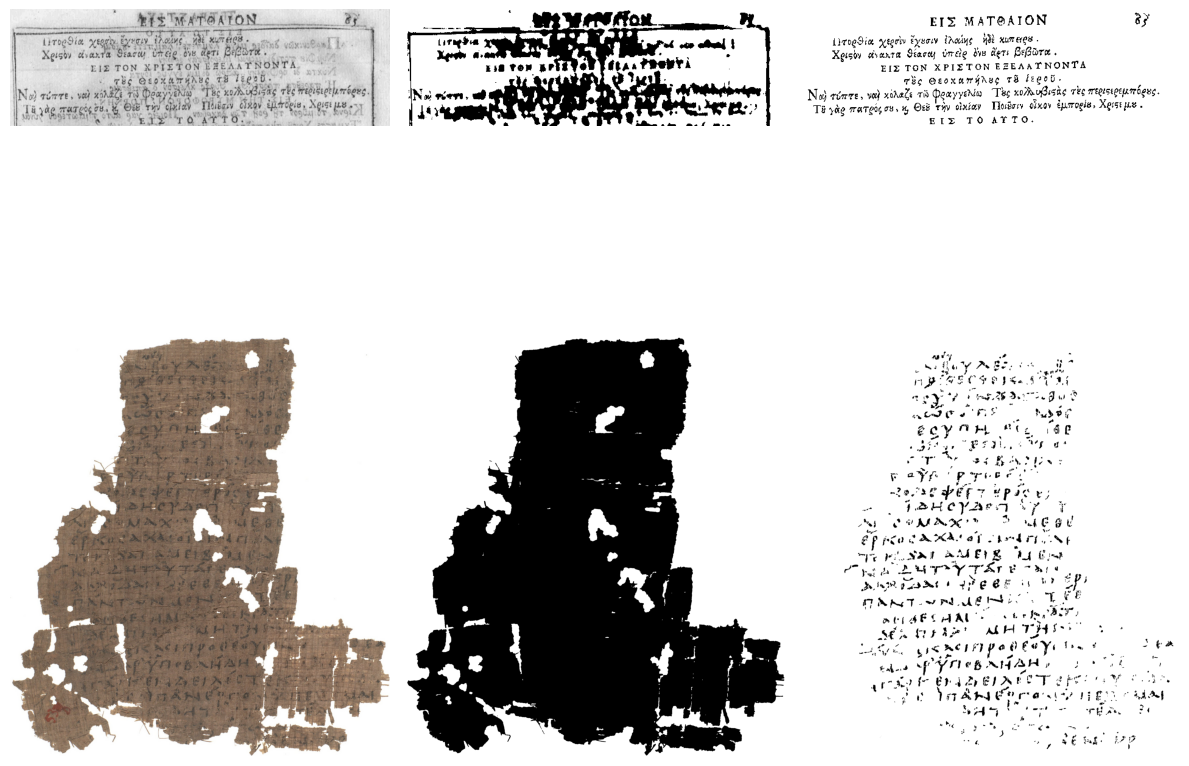

In [7]:
p, r, f, t, b, gt, og = apply_thresholds(data, method="otsu", retain=True)
results.loc[len(results)] = ["Otsu", cross, p[0], r[0], f[0]]
p, r, f, t, b, gt, og = apply_thresholds(data, denoise=True, method="otsu", retain=True)
results.loc[len(results)] = ["Otsu", tick, p[0], r[0], f[0]]
show_images(og, b, gt,2)

# Adaptive threshold


Threshold:0 precision:0.3057976107481974, recall:0.7210961903246066
TP:2260744 FP:5132198, FN:874405
Threshold:0 precision:0.3057976107481974, recall:0.7210961903246066
TP:2260744 FP:5132198, FN:874405


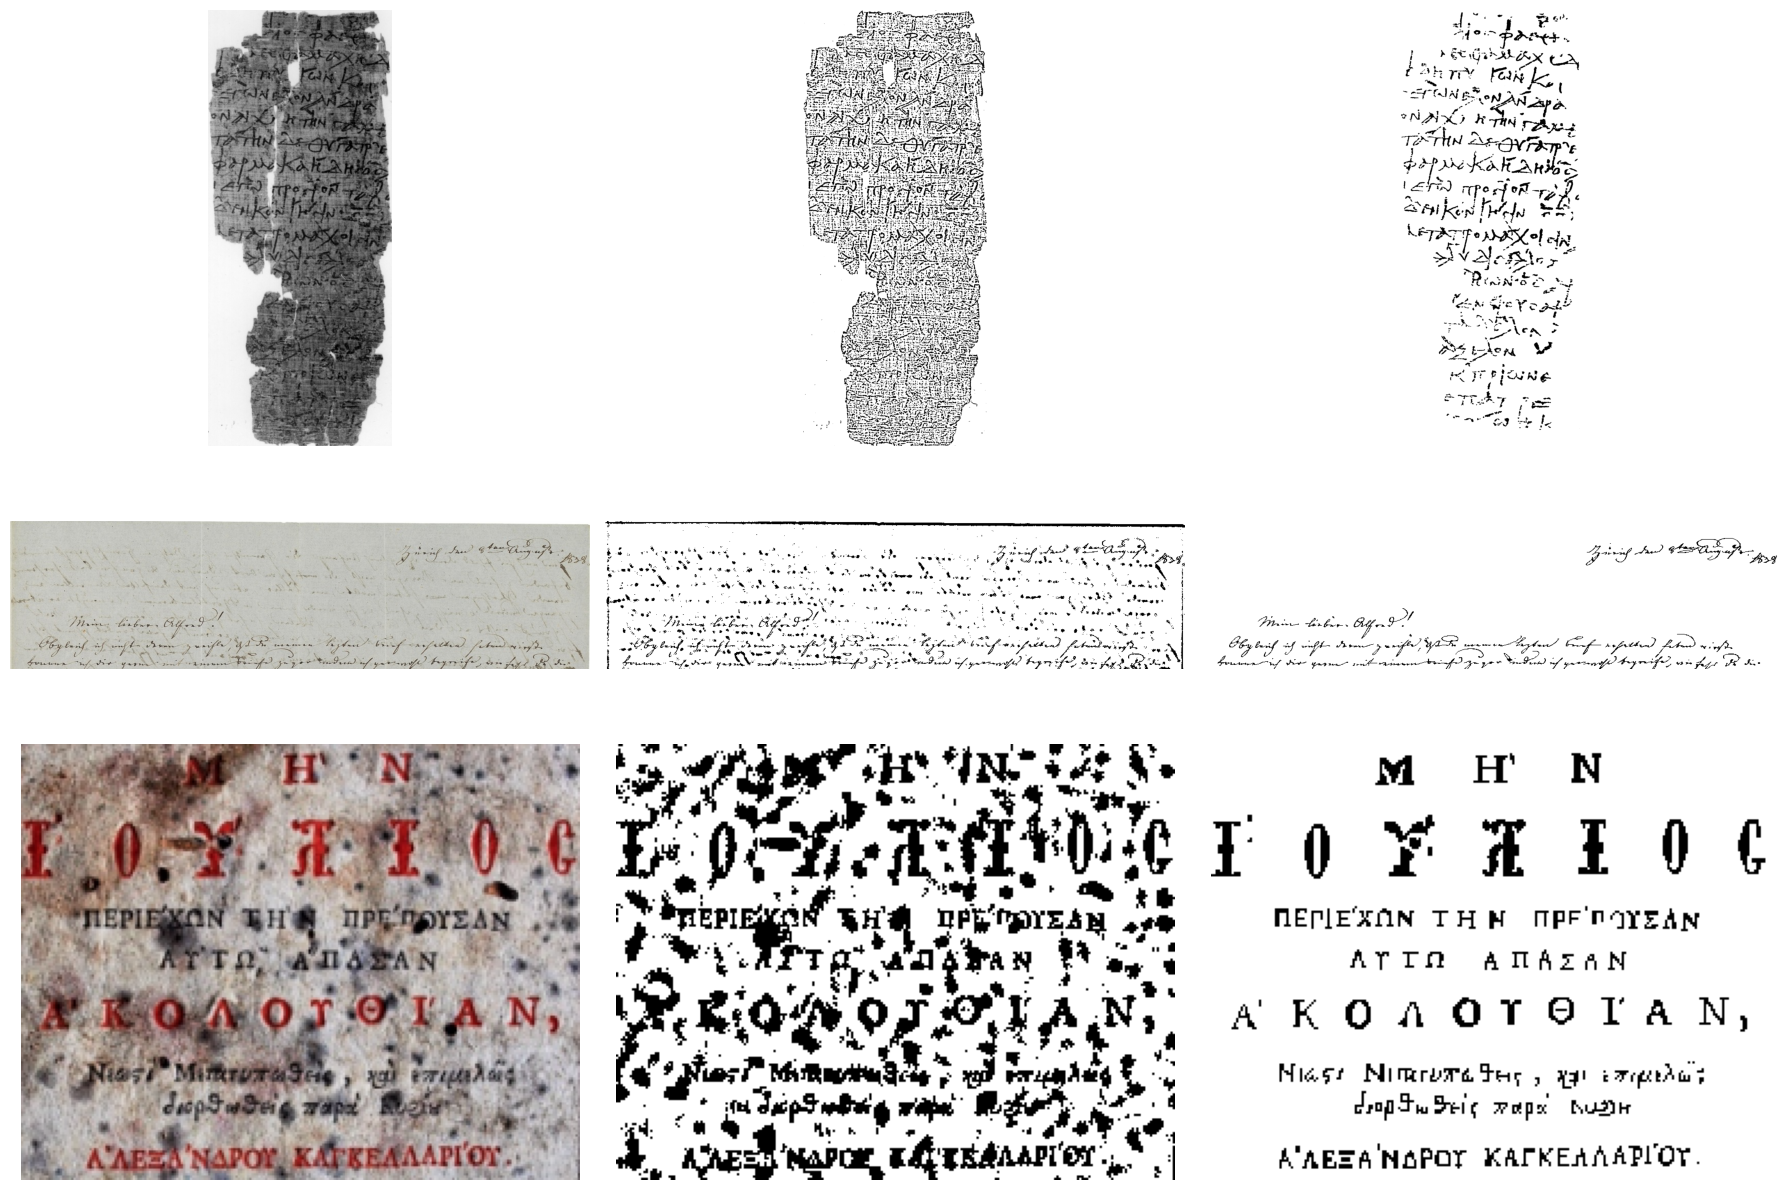

In [15]:
p, r, f, t, b, gt, og = apply_thresholds(
    data, denoise="False", method="adaptive", retain=True
)
results.loc[len(results)] = ["Adaptive Gaussian", cross, p[0], r[0], f[0]]
p, r, f, t, b, gt, og = apply_thresholds(
    data, denoise=True, method="adaptive", retain=True
)
results.loc[len(results)] = ["Adaptive Gaussian", tick, p[0], r[0], f[0]]
show_images(og, b, gt)

Threshold:0 precision:0.4008167409395145, recall:0.6137309582415381
TP:1924138 FP:2876405, FN:1211011
Threshold:0 precision:0.5814684081273157, recall:0.41272743336919554
TP:1293962 FP:931373, FN:1841187


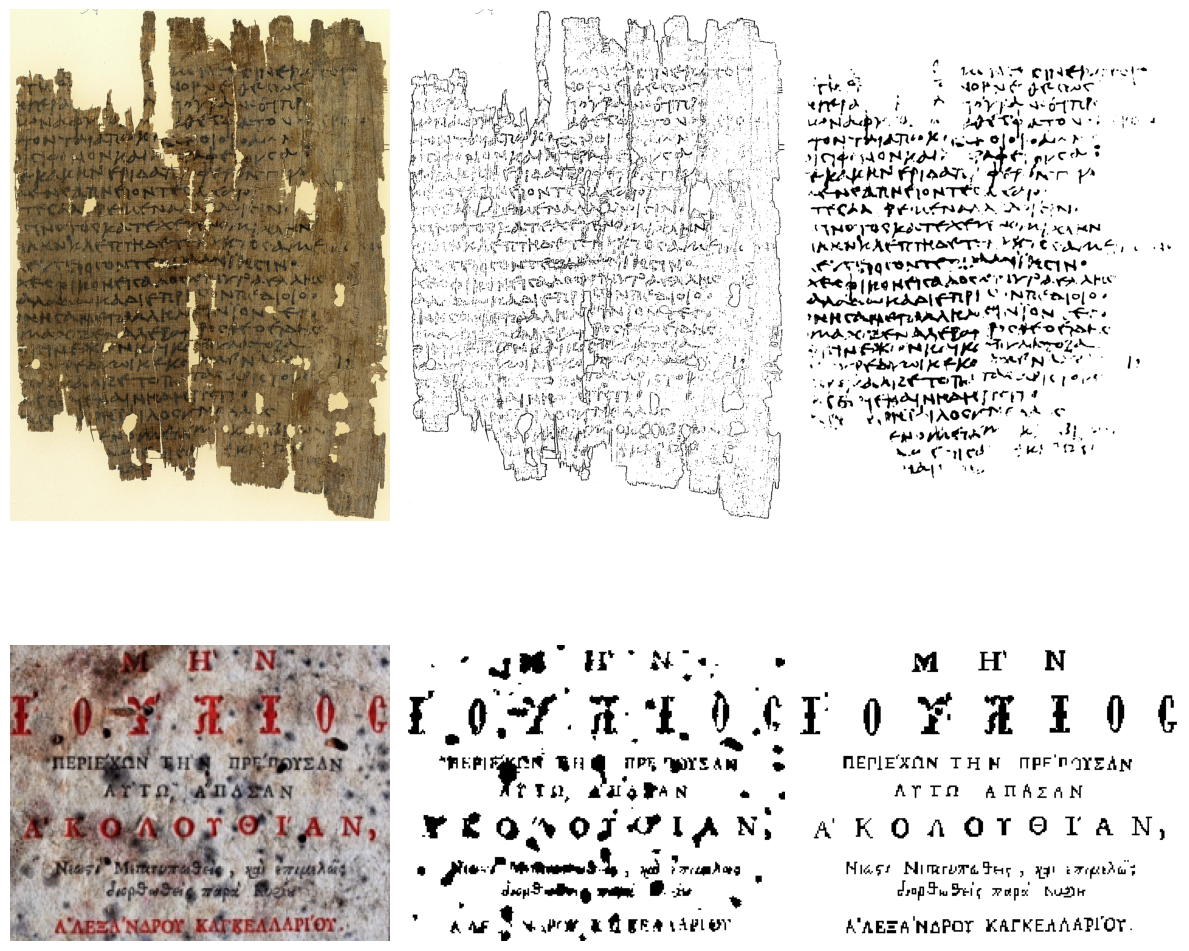

In [18]:
p, r, f, t, b, gt, og = apply_thresholds(data, method="sauvola", retain=True)
results.loc[len(results)] = ["Sauvola", cross, p[0], r[0], f[0]]
p, r, f, t, b, gt, og = apply_thresholds(
    data, method="sauvola", denoise=True, retain=True
)
results.loc[len(results)] = ["Sauvola", tick, p[0], r[0], f[0]]
show_images(og, b, gt,2)

Threshold:0 precision:0.4008167409395145, recall:0.6137309582415381
TP:1924138 FP:2876405, FN:1211011
Threshold:0 precision:0.5814684081273157, recall:0.41272743336919554
TP:1293962 FP:931373, FN:1841187


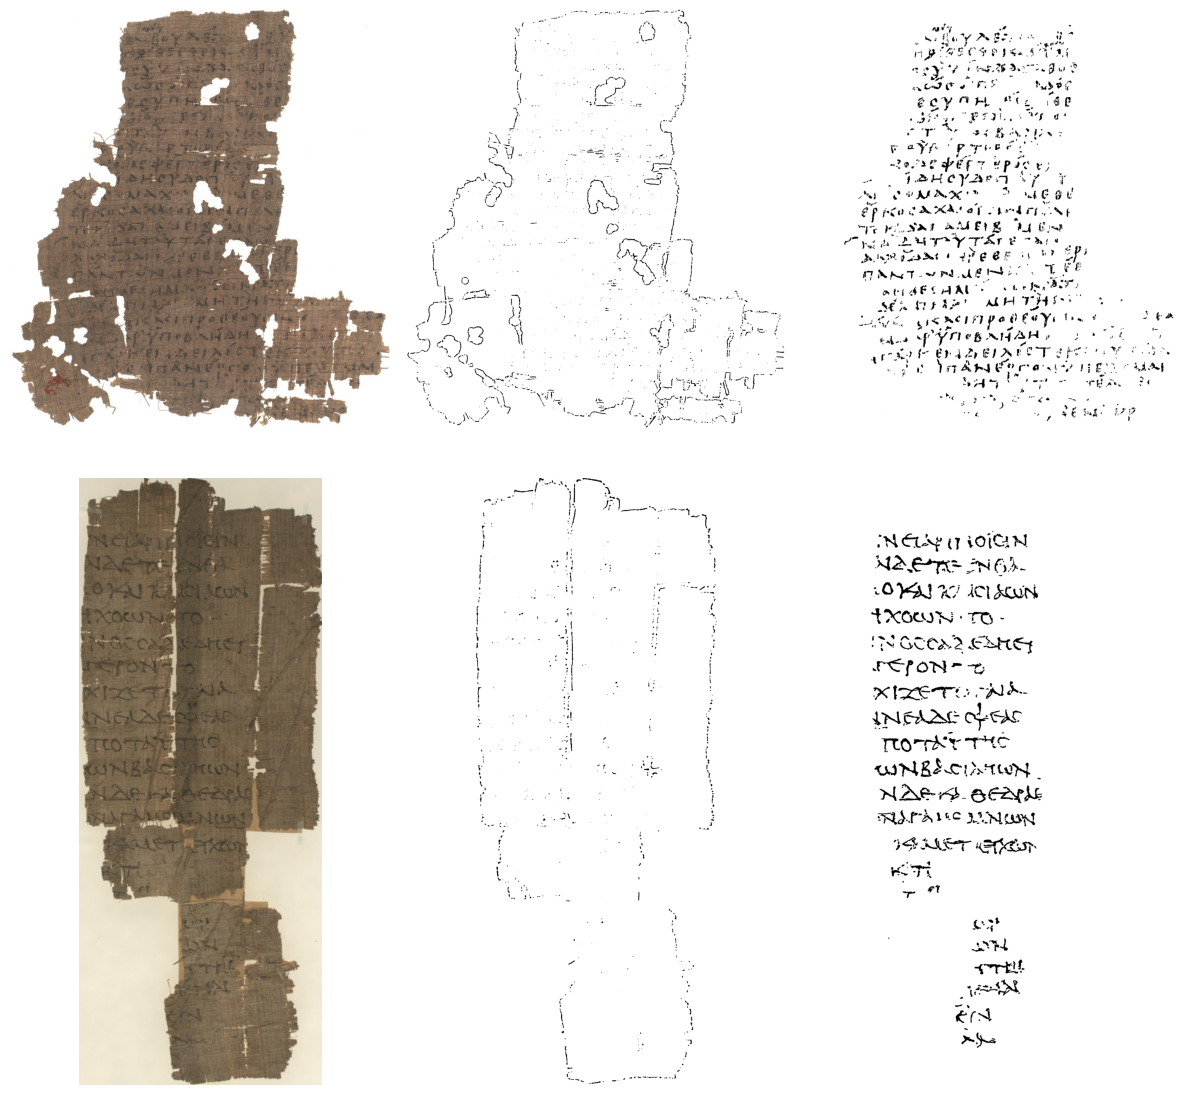

In [10]:
p, r, f, t, b, gt, og = apply_thresholds(data, method="niblack", retain=True)
results.loc[len(results)] = ['Niblack',cross, p[0], r[0], f[0]]
p, r, f, t, b, gt, og = apply_thresholds(data, method="niblack",denoise=True, retain=True)
results.loc[len(results)] = ['Niblack',tick, p[0], r[0], f[0]]
show_images(og, b, gt,2)


# Result Analysis


## Quantitative

In [11]:
results

Method Denoising  Precision    Recall  F Measure
0        Global (69)         ✗   0.618420  0.612801   0.615598
1        Global (76)         ✓   0.646560  0.635069   0.640763
2               Otsu         ✗   0.136390  0.994405   0.239879
3               Otsu         ✓   0.129576  0.992466   0.229224
4  Adaptive Gaussian         ✗   0.305798  0.721096   0.429469
5  Adaptive Gaussian         ✓   0.305798  0.721096   0.429469
6            Sauvola         ✗   0.400817  0.613731   0.484933
7            Sauvola         ✓   0.581468  0.412727   0.482778
8            Niblack         ✗   0.400817  0.613731   0.484933
9            Niblack         ✓   0.581468  0.412727   0.482778

## Qualitative